# TNR Balance Framework
In order to properly balance the game we need a reference framework. The goal of this framework is to define the rough overall scale e.g. damage etc in simple settings, while not neccesarily strictly accounting for secondary effects etc. which can tilt balance on a more granular level. In this proposal, we parameterize this overall framework by a set of interpretable variables, based on which various formulas can be derived. The objectives of the framework:

**Levels & Capping**
* Take about 12 months of play to cap [considering ~6h play per day]

**Pools**
* Keep pools under control, so as to not end in an exponential number situation (i.e. no cookie clicker situation).
* Aim for +1 regen at each rank (keep pools under control!)

**Battle Length**
* Should take ~10 hits to kill user of same strength with equal stats distribution.
* Should take ~5 hits to kill user of same strength with favorable stats distribution.
* Should take ~3 hits to kill user 10x weaker with same stats distribution.
* Should take ~1 hit to kill user 10x weaker with favorable stats distribution.

**Ryo**
* Ryo from ~2 arena fights should be enough to get out hospital at any level
* Ryo from 2^[jutsu level] arena fights should be enough to level jutsu

## 1. Settings

In [6]:
POOL_PER_LEVEL = 10
REGEN_PER_RANK = 1
ENERGY_SPENT_PER_SECOND = 0.1 # Training Stats per Second
EXTRA_EXP_REQUIRED_PER_LEVEL = 500
HOSPITAL_COST_PER_HP = 0.25
RYO_GAIN_LEVEL_ADDITION = 1
RYO_GAIN_MIN_PER_LEVEL = 15
RYO_GAIN_MAX_PER_LEVEL = 20
LEVEL_2_RANK = {10: 2, 20: 3, 50: 4, 80: 5, 100: 6}

# Estimates for battle activity against equal opponents (elo gain 16 with K-factor 32)
ESTIMATED_HIGH_BATTLES_PER_HOUR = 60
ESTIMATED_LOW_BATTLES_PER_HOUR = 20
ESTIMATED_BATTLES_PER_HOUR = 40
ELO_GAIN = 16

## Setup Base DataFrame

In [7]:
# Required imports
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

# Create Dataframe
df = pd.DataFrame({'User Level': np.arange(1, 100)})
df['Regen'] = df['User Level'].apply(lambda x: 1 if x in LEVEL_2_RANK else 0).cumsum() + 1
df['Experience'] = df['User Level'].apply(lambda x: EXTRA_EXP_REQUIRED_PER_LEVEL * x).cumsum()
df['Pool Size'] = df['User Level'].apply(lambda x: POOL_PER_LEVEL * x + 100)
df['Pool Regen Time [s]'] = df['Pool Size'] / df['Regen']
df['Trainings/Hour'] = 3600 / (df['Pool Regen Time [s]'] + df['Pool Size'] * ENERGY_SPENT_PER_SECOND)
df['Stats/Hour [training]'] = df['Pool Size'] * ENERGY_SPENT_PER_SECOND * df['Trainings/Hour']
df['Stats/Hour [battle]'] = ESTIMATED_BATTLES_PER_HOUR * ELO_GAIN
df['Low Stats/Hour [battle]'] = ESTIMATED_LOW_BATTLES_PER_HOUR * ELO_GAIN
df['High Stats/Hour [battle]'] = ESTIMATED_HIGH_BATTLES_PER_HOUR * ELO_GAIN
df['Total Stats/Hour'] = df['Low Stats/Hour [battle]'] + df['High Stats/Hour [battle]']
df['hospital_cost'] = df['Pool Size'] * HOSPITAL_COST_PER_HP

# Ryo gain from battle
df['Battles for Hospital'] = (df['Pool Size'] * HOSPITAL_COST_PER_HP) / ((RYO_GAIN_MIN_PER_LEVEL + RYO_GAIN_MAX_PER_LEVEL) / 2 + df['User Level'] * RYO_GAIN_LEVEL_ADDITION)
df['Low Battles for Hospital'] = (df['Pool Size'] * HOSPITAL_COST_PER_HP) / (RYO_GAIN_MIN_PER_LEVEL + df['User Level'] * RYO_GAIN_LEVEL_ADDITION)
df['High Battles for Hospital'] = (df['Pool Size'] * HOSPITAL_COST_PER_HP) / (RYO_GAIN_MAX_PER_LEVEL + df['User Level'] * RYO_GAIN_LEVEL_ADDITION)
df = df.set_index('User Level')

## 2. Pools, Training, & Levelling

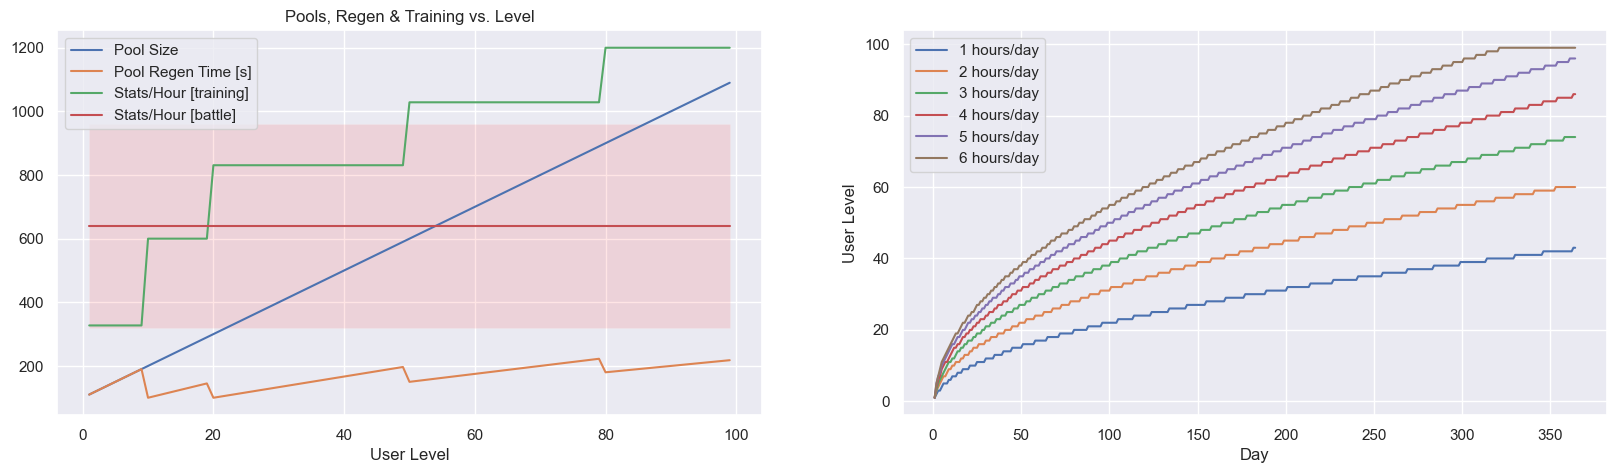

In [8]:
# Set up subplots
_, axes = plt.subplots(1, 2, figsize=(20, 5))

# Create pools, regen & training plots
axes[0].fill_between(df.index, df['Low Stats/Hour [battle]'], df['High Stats/Hour [battle]'],alpha=0.1, facecolor="red")
df.plot(y='Pool Size', ax=axes[0])
df.plot(y='Pool Regen Time [s]', ax=axes[0])
df.plot(y='Stats/Hour [training]', ax=axes[0])
df.plot(y='Stats/Hour [battle]', ax=axes[0])
axes[0].set_title('Pools, Regen & Training vs. Level')

# Create levelling & cap plots
for hours_per_day in [1, 2, 3, 4, 5, 6]:
    column = f"{hours_per_day} hours/day"
    time_df = pd.DataFrame({'Day': np.arange(1, 365), column: 1, 'experience': 0})
    for day, row in time_df.iterrows():
        time_df.loc[day:, column] = df.assign(diff=np.abs(df.Experience - time_df.loc[day].experience)).sort_values('diff').index[0]
        time_df.loc[day:, 'experience'] += hours_per_day * df.loc[row[column], 'Total Stats/Hour']
    time_df.plot(x='Day', y=column, ax=axes[1])
    axes[1].set_ylabel('User Level')
plt.show()

## 3. Ryo Gain

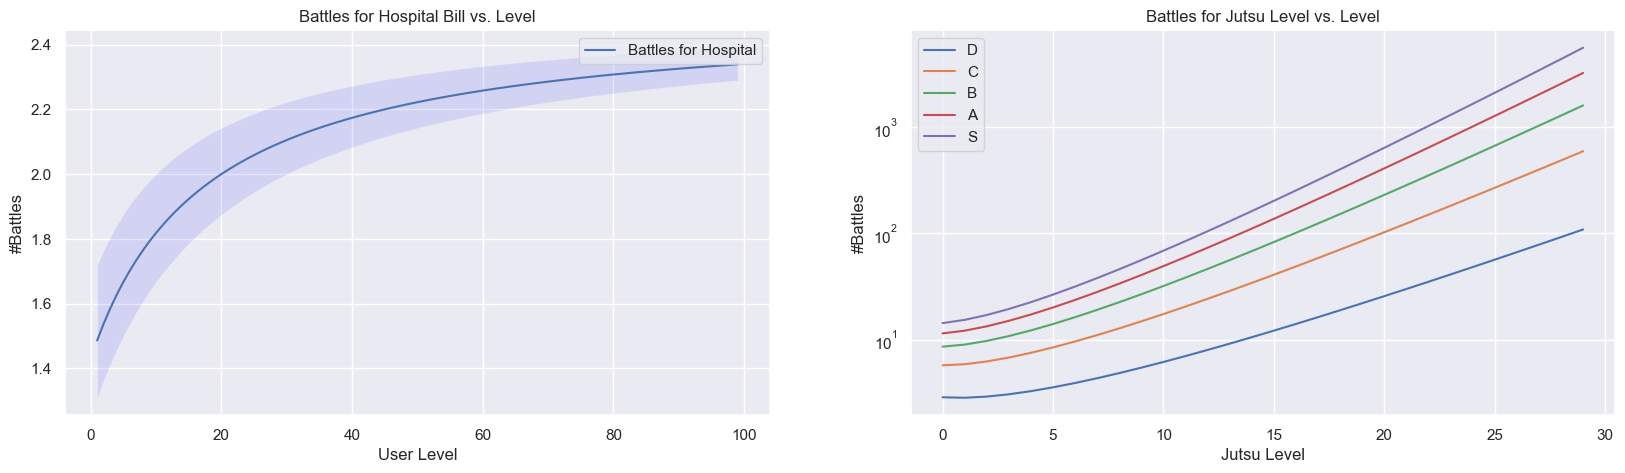

In [9]:
# Setup 2 subplots
_, axes = plt.subplots(1, 2, figsize=(20, 5))

# Create a plot for hospital bills
axes[0].fill_between(df.index, df['Low Battles for Hospital'], df['High Battles for Hospital'], alpha=0.1, facecolor="blue")
df.plot(y='Battles for Hospital', ax=axes[0])
axes[0].set_title('Battles for Hospital Bill vs. Level')
axes[0].set_ylabel('#Battles')

# Create a plot for jutsu bills
jutsu_ranks = {'D': 50, 'C': 100, 'B': 150, 'A': 200, 'S': 250}
for rank, base in jutsu_ranks.items():
    costs = []
    for level in np.arange(30):
        cost = np.power(base, 1+level/20) 
        # Ryo gained per battle (assume jutsu level 1/4th of user level)
        ryo_gain = (RYO_GAIN_MIN_PER_LEVEL + RYO_GAIN_MAX_PER_LEVEL) / 2 + level * 4 * RYO_GAIN_LEVEL_ADDITION
        costs.append(cost / ryo_gain)
    axes[1].plot(np.arange(30), costs, label=rank)
axes[1].set_title('Battles for Jutsu Level vs. Level')
axes[1].set_ylabel('#Battles')
axes[1].set_xlabel('Jutsu Level')
axes[1].set_yscale('log')
axes[1].legend()

## 4. Battle Formula
Beyond the goals for battle length stated above, another aim for the battle formula should be simplicity - previous cores have all had somewhat overly complicated calculations, which preferably should be avoided. Many things have to be considered for the battle formula to keep things in check. These include:

* Must be stable across all user levels
* Must scale well with jutsu levels. Each jutsu has a based "power" and a "powerPerLevel" attribute

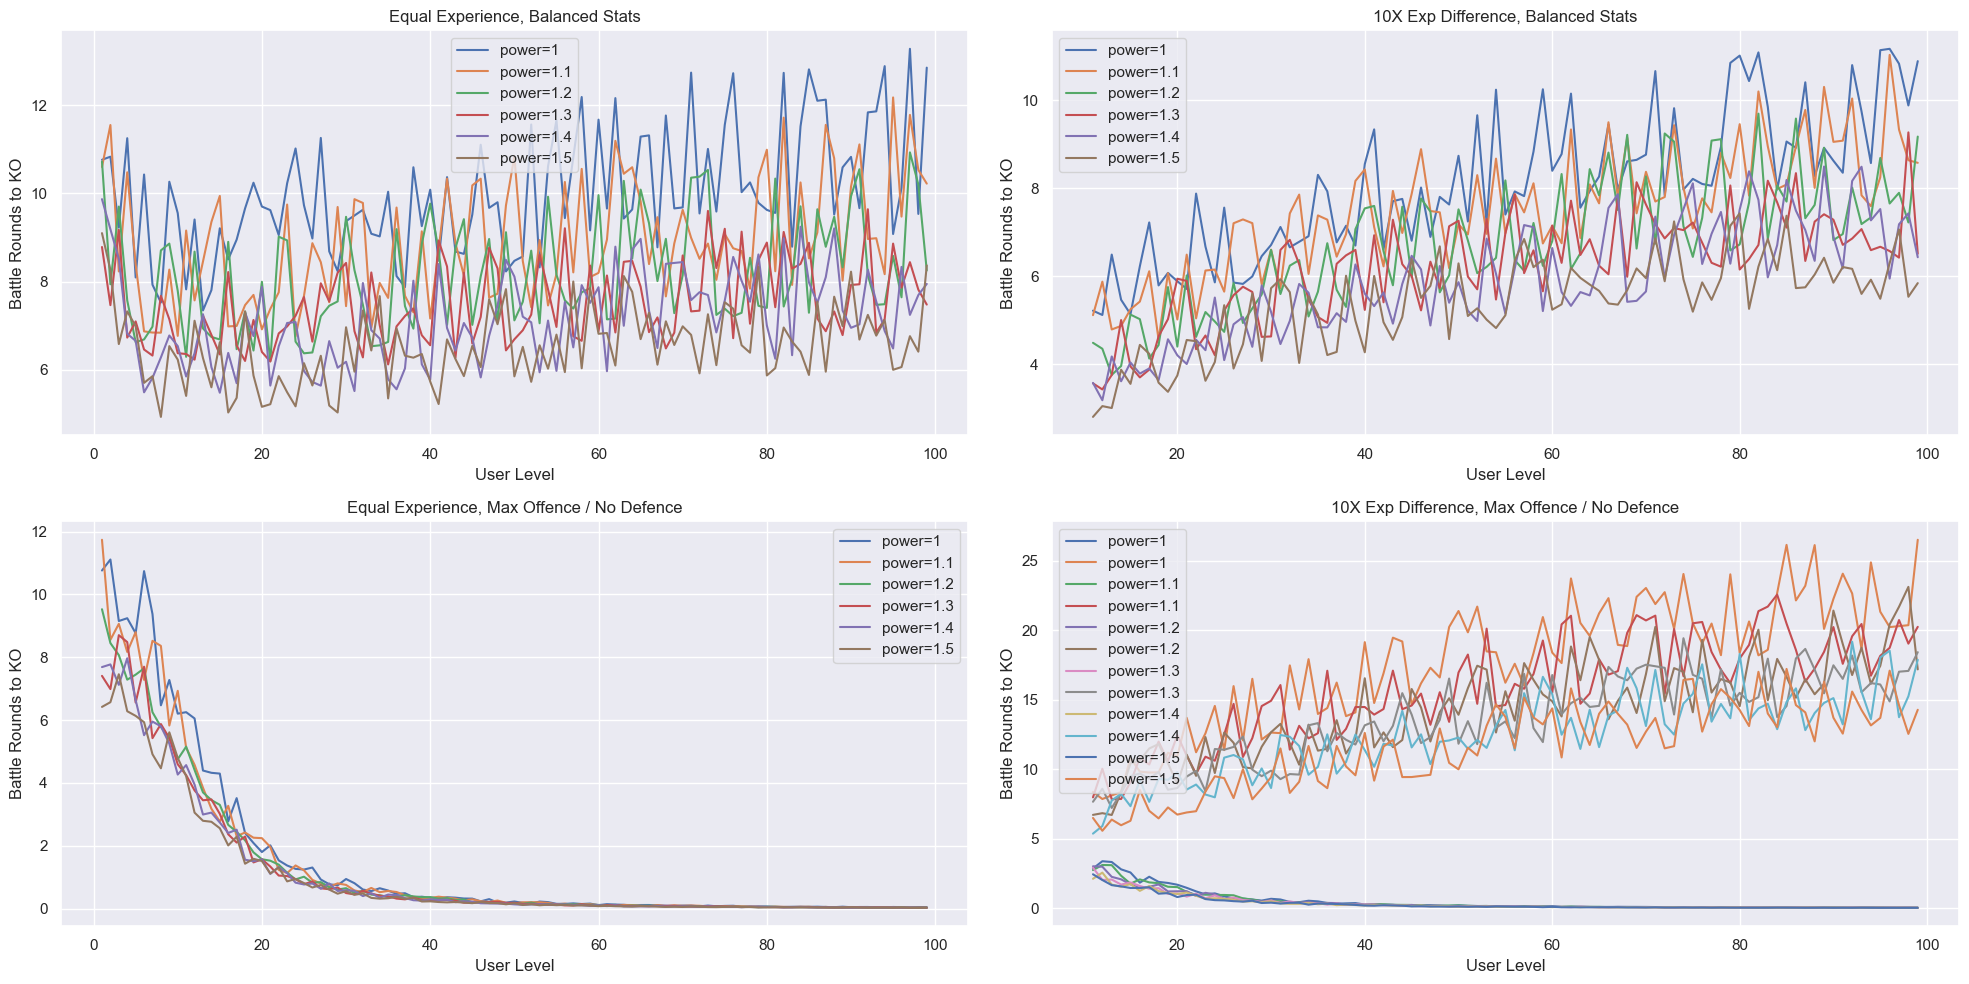

In [11]:
from dataclasses import dataclass

@dataclass
class UserStats:
    nin_offence: int = 10
    gen_offence: int = 10
    tai_offence: int = 10
    buki_offence: int = 10
    nin_defence: int = 10
    gen_defence: int = 10
    tai_defence: int = 10
    buki_defence: int = 10
    strength: int = 10
    willpower: int = 10
    intelligence: int = 10
    speed: int = 10

# Extract all the stats from the data class
GENERALS = ['strength', 'willpower', 'intelligence', 'speed']
OFFENCES = ['nin_offence', 'gen_offence', 'tai_offence', 'buki_offence']
DEFENCES = ['nin_defence', 'gen_defence', 'tai_defence', 'buki_defence']

LEVEL_IMPACT = 1.75
EXP_SCALING = 0.39
DMG_SCALING = 8
UNDERDOG = 3

def battleCalc(attacker: UserStats, defender: UserStats, power=1):
    calcs = []
    def _internal(attack: int, defence: int):
        return DMG_SCALING + ((attack / (defence**UNDERDOG)) ** LEVEL_IMPACT) + (attack ** EXP_SCALING)
    for offence, defence in zip(OFFENCES, DEFENCES):
        calcs.append(_internal(getattr(attacker, offence), getattr(defender, defence)))   
    for general in GENERALS:
        calcs.append(_internal(getattr(attacker, general), getattr(defender, general)))
    mean = np.mean(calcs)
    return (power * mean * DMG_SCALING / 10) * round(random.uniform(.8,1.1),2)

# Prepare subplots for our 4 scenarios
_, axes = plt.subplots(2, 2, figsize=(20, 10))
axes[0, 0].set_title('Equal Experience, Balanced Stats')
axes[0, 0].set_ylabel('Battle Rounds to KO')
axes[0, 0].set_xlabel('User Level')
axes[1, 0].set_title('Equal Experience, Max Offence / No Defence')
axes[1, 0].set_ylabel('Battle Rounds to KO')
axes[1, 0].set_xlabel('User Level')
axes[0, 1].set_title('10X Exp Difference, Balanced Stats')
axes[0, 1].set_ylabel('Battle Rounds to KO')
axes[0, 1].set_xlabel('User Level')
axes[1, 1].set_title('10X Exp Difference, Max Offence / No Defence')
axes[1, 1].set_ylabel('Battle Rounds to KO')
axes[1, 1].set_xlabel('User Level')
plt.tight_layout()

# Try different power levels (determined by jutsu & jutsu level)
for power in [1,1.1,1.2,1.3,1.4,1.5]:

    # Equal, Balanced Stats
    results = []
    for level, data in df.iterrows():
        balanced = data.Experience / 12
        user = UserStats(nin_offence=balanced, gen_offence=balanced, tai_offence=balanced, buki_offence=balanced, nin_defence=balanced, gen_defence=balanced, tai_defence=balanced, buki_defence=balanced, strength=balanced, willpower=balanced, intelligence=balanced, speed=balanced)
        results.append(data['Pool Size'] / battleCalc(user, user, power=power))
    axes[0, 0].plot(df.index, results, label=f'power={power}')
    axes[0, 0].legend()

    # 10X difference, Balanced Stats
    results = []
    for level, data in df.iloc[10:].iterrows():
        strong = data.Experience / 12
        attacker = UserStats(nin_offence=strong, gen_offence=strong, tai_offence=strong, buki_offence=strong, nin_defence=strong, gen_defence=strong, tai_defence=strong, buki_defence=strong, strength=strong, willpower=strong, intelligence=strong, speed=strong)
        weak = strong / 5
        defender = UserStats(nin_offence=weak, gen_offence=weak, tai_offence=weak, buki_offence=weak, nin_defence=weak, gen_defence=weak, tai_defence=weak, buki_defence=weak, strength=weak, willpower=weak, intelligence=weak, speed=weak)
        results.append(df.iloc[level-10]['Pool Size'] / battleCalc(attacker, defender, power=power))
    axes[0, 1].plot(df.index[10:], results, label=f'power={power}')
    axes[0, 1].legend()

    # Equal, Favorable stats
    results = []
    for level, data in df.iterrows():
        stat = data.Experience / 4
        offenceUser = UserStats(nin_offence=stat, gen_offence=stat, tai_offence=stat, buki_offence=stat)
        results.append(data['Pool Size'] / battleCalc(offenceUser, offenceUser, power=power))
    axes[1, 0].plot(df.index, results, label=f'power={power}')
    axes[1, 0].legend()

   # 10X difference, Favorable stats
    results = []
    for level, data in df.iloc[10:].iterrows():
        stat = data.Experience / 4
        offenceUser = UserStats(nin_offence=stat, gen_offence=stat, tai_offence=stat, buki_offence=stat)
        results.append(df.iloc[level-10]['Pool Size'] / battleCalc(offenceUser, offenceUser, power=power))
    axes[1, 1].plot(df.index[10:], results, label=f'power={power}')
    axes[1, 1].legend()

    # 10X difference, Favorable Defender stats
    results = []
    for level, data in df.iloc[10:].iterrows():
        strong = data.Experience / 12
        defender = UserStats(nin_offence=strong, gen_offence=strong, tai_offence=strong, buki_offence=strong, nin_defence=strong, gen_defence=strong, tai_defence=strong, buki_defence=strong, strength=strong, willpower=strong, intelligence=strong, speed=strong)
        weak = strong / 10
        attacker = UserStats(nin_offence=weak, gen_offence=weak, tai_offence=weak, buki_offence=weak, nin_defence=weak, gen_defence=weak, tai_defence=weak, buki_defence=weak, strength=weak, willpower=weak, intelligence=weak, speed=weak)
        results.append(df.iloc[level-10]['Pool Size'] / battleCalc(attacker, defender, power=power))
    axes[1, 1].plot(df.index[10:], results, label=f'power={power}')
    axes[1, 1].legend()
